<a href="https://colab.research.google.com/github/JoseFerrer/Intro_Signal_Proc/blob/main/Clase_4_1_An%C3%A1lisis_de_ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A Real-Time QRS Detection Algorithm**

### **Jiapu Pan and Willis J. Tompkins,**

**Resumen:** Hemos desarrollado un algoritmo en tiempo real para la detección de los complejos QRS de las señales de ECG. Reconoce de manera confiable los complejos QRS basados en análisis digitales de pendiente, amplitud y ancho. Un filtro digital especial de paso de banda reduce las falsas detecciones causadas por los diversos tipos de interferencia presentes en las señales de ECG. Este filtrado permite el uso de umbrales bajos, lo que aumenta la sensibilidad de detección. El algoritmo ajusta automáticamente los umbrales y parámetros periódicamente para adaptarse a los cambios de ECG como la morfología QRS y la frecuencia cardíaca. Para la base de datos estándar de arritmia MIT / BIH de 24 h, este algoritmo detecta correctamente el 99.3 por ciento de los complejos QRS.

Se desea obtener el complejo QRS

![Complejo QRS](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8c/QRS_complex.png/220px-QRS_complex.png)

Librerías que utilizaremos:



*   Numpy
*   Scipy
*   Matplotlib
*   Pandas
*   Google Colab con Google Drive

### **Nota:** 
En esta clase introducimos al alumno una herramienta que podría ser de mucha ayuda uniendo Google Colabs con los archivos que se encuentran en Google Drive. Para ello utilizamos la librería drive que esta dentro de la librería de google.colab.



```
from google.colab import drive
drive.mount('/content/gdrive')
```





In [ ]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd 
from scipy.fft import fft
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **Obtener el data set**

In [ ]:
# Cargar la data
new_data = pd.read_csv("/content/gdrive/My Drive/ECG Signal/rec_1.csv", skiprows=[1], quotechar="'", index_col=0)
print(new_data)

              ECG I
Elapsed time       
0:00.000     -0.085
0:00.002     -0.080
0:00.004     -0.070
0:00.006     -0.075
0:00.008     -0.095
...             ...
0:19.990     -0.055
0:19.992     -0.060
0:19.994     -0.065
0:19.996     -0.080
0:19.998     -0.080

[10000 rows x 1 columns]


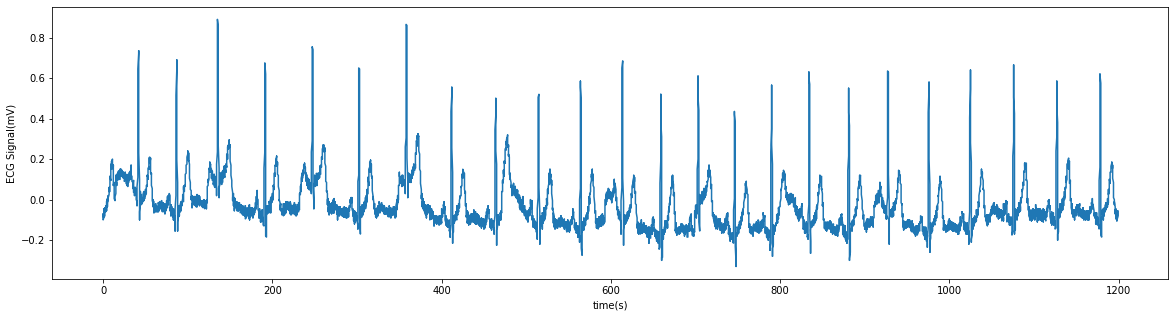

In [ ]:
# A numpy
t = pd.to_datetime(new_data.index)
td = t - t.min()
mtime = td.total_seconds()
voltaje = new_data.to_numpy()
plt.figure(figsize=(20,5))
plt.plot(mtime, voltaje)
plt.ylabel('ECG Signal(mV)')
plt.xlabel('time(s)')
plt.show()

## **Analizamos de la señal en el espectro de la frecuencia**

Conociendo los datos de adquisición de la señal, analicemos ahora el espectro de Fourier.

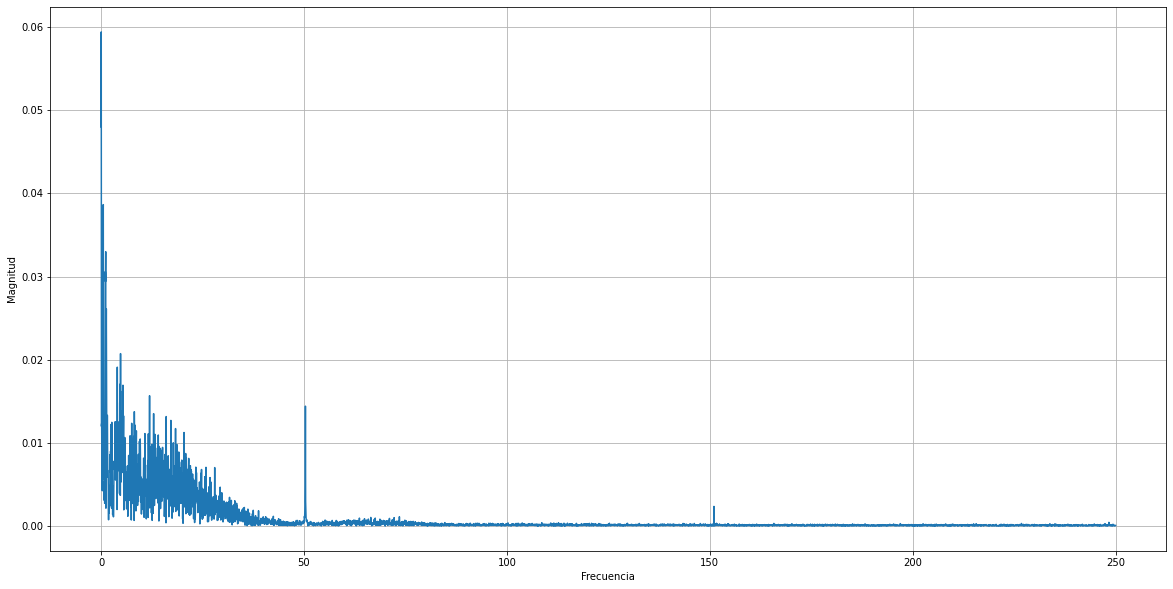

In [ ]:
# Analizar el Fourier
ecg_senal = voltaje[:,0]
# Periodo de 2ms (0.002s) o frecuencia de 500 Hz
T = 0.002
N = len(ecg_senal)
yf = fft(ecg_senal)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.figure(figsize=(20,10))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.xlabel("Frecuencia")
plt.ylabel("Magnitud")
plt.show()

Como estamos viendo, la señal eléctrica ha generado ruido en 50 Hz y armónicos en 150 Hz que debemos filtrar pero para ello debemos tener en cuenta que estas señales deben tratarse a través de filtros digitales. Para ello abordaremos algunos temas.

### **La Transformada Z**

La transformada Z convierte una señal real o compleja que está definida en el dominio del tiempo discreto en una representación en el dominio de la frecuencia compleja.



1.   Transformada Z bilateral: 
      $$X(z)=Z\{x[n]\}=\sum_{n=-\infty}^{\infty} x[n] z^{-n}$$
2.   Transformada Z unilateral
      $$X^{+}(z)=Z^{+}\{x[n]\}=\sum_{n=0}^{\infty} x[n] z^{-n}$$

Donde $z=A e^{j \omega}$.

Ahora analicemos a la sumatoria representando a $z$ como un número cualquiera que puede ser representado de la siguiente manera:

$$\sum_{n=-\infty}^{\infty} r^{n}$$

Si limitamos esta sumatoria en un rango de valores $n=[0,+\infty]$. Notamos que esta sumatoria tiene una solución similar a una serie geométrica donde:

$$\sum_{n=0}^{N} r^{n}=\frac{1-r^{n+1}}{1-r}$$

$$\lim_{N\to\infty} \sum_{n=0}^{N} r^{n}=\lim_{N\to\infty}\frac{1-r^{N+1}}{1-r}=$$

Para que esta sumatoria converja en un área donde esta exista, es decir, donde de como resultado un valor finito, se debe cumplir que: $|r|<1$. Entonces esto nos da:

$$\sum_{n=0}^{\infty} r^{n}=\frac{1}{1-r}$$


Retomemos la Transformada Z unilateral,

$$X^{+}(z)=Z^{+}\{x[n]\}=\sum_{n=0}^{\infty} x[n] z^{-n}$$

Ahora analicemos el ejemplo más sencillo donde: $x[n]=a^{n}u[n]$ obtenemos:

$$X(z)=\sum_{n=-\infty}^{\infty} a^{n}u[n]z^{-n}=\sum_{n=0}^{\infty} a^{n}z^{-n}=\sum_{n=0}^{\infty}\left(az^{-1}\right)^{n}$$

Entonces tenemos que:

$$X(z)=\frac{1}{1-az^{-1}}$$

Para que converja necesitamos que $|z|>|a|$, por ejemplo si $a=0.5$, tenemos la siguiente ROC o  Región de Convergencia:

![Region de Convergencia](https://upload.wikimedia.org/wikipedia/commons/e/e5/Region_of_convergence_0.5_causal.svg)


### **Propiedades de la Transformada Z**

Linealidad:
$$a_{1} x_{1}[n]+a_{2} x_{2}[n] \to a_{1} X_{1}(z)+a_{2} X_{2}(z)$$

Desplazamiento en el tiempo: 
$$x[n-k] \to z^{-k} X(z)$$

Escalamiento en el espacio Z:
$$a^{n} x[n] \to X\left(a^{-1} z\right)$$

Convolución:
$$x_{1}[n] * x_{2}[n] \to X_{1}(z) X_{2}(z)$$

### **Filtros FIR e IRR**

Filtros FIR:
$$y_{n}=\sum_{k=0}^{N-1} b_{k} x_{n-k}$$
$$y_{n}=\sum_{k=0}^{N-1} h_{k} x_{n-k}$$
$$H(z)=\sum_{k=0}^{N-1} h_{k} z^{-k}=h_{0}+h_{1} z^{-1}+\cdots+h_{N-1} z^{-(N-1)}$$

![Filtro FIR](https://upload.wikimedia.org/wikipedia/commons/3/35/FIR_estr.PNG)


Filtros IIR:
$$y_{n}=b_{0} x_{n}+b_{1} x_{n-1}+\cdots+b_{N} x_{n-N}-a_{1} y_{n-1}-a_{2} y_{n-2}-\cdots-a_{M} y_{n-M}$$
$$H(z)=\frac{\sum_{k=0}^{N} b_{k} z^{-k}}{1+\sum_{k=1}^{M} a_{k} z^{-k}}$$

![Filtros IIR](https://upload.wikimedia.org/wikipedia/commons/d/d5/IIR-filter.png)

Como vimos anteriormente la señal posee un ruido proveniente de la señal eléctrica en 50 Hz y armónicos en 150 Hz que debemos filtrar, para ello utilizaremos filtros Notch digitales utilizando el modulo signal de scipy (iirnotch y lfilter).

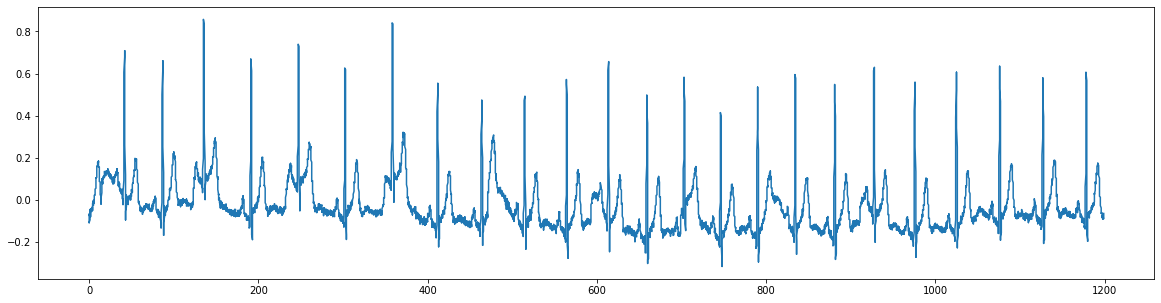

In [ ]:
# Utilizar filtros Notch para quitar frecuencias que hagan ruido
from scipy.signal import iirnotch, lfilter
fs = 1/T  # Frecuencia de muestreo (Hz)
f0 = 50.0  # Frecuencia que queremos filtrar (Hz)
Q = 20.0  # Factor de Calidad
# Diseño de filtro notch
b, a = iirnotch(f0, Q, fs)
y = lfilter(b, a, ecg_senal)
y = lfilter(b, a, y)
fs = 1/T  # Frecuencia de muestreo (Hz)
f0 = 150.0  # Frecuencia que queremos filtrar (Hz)
Q = 7.0  # Factor de Calidad
# Diseño de filtro notch
b, a = iirnotch(f0, Q, fs)
y = lfilter(b,a,y)
plt.figure(figsize=(20,5))
#plt.xlim(0,200)
plt.plot(mtime,y)
plt.show()

Ahora veamos las atenuaciones de estos filtros en el espectro de frecuencia.

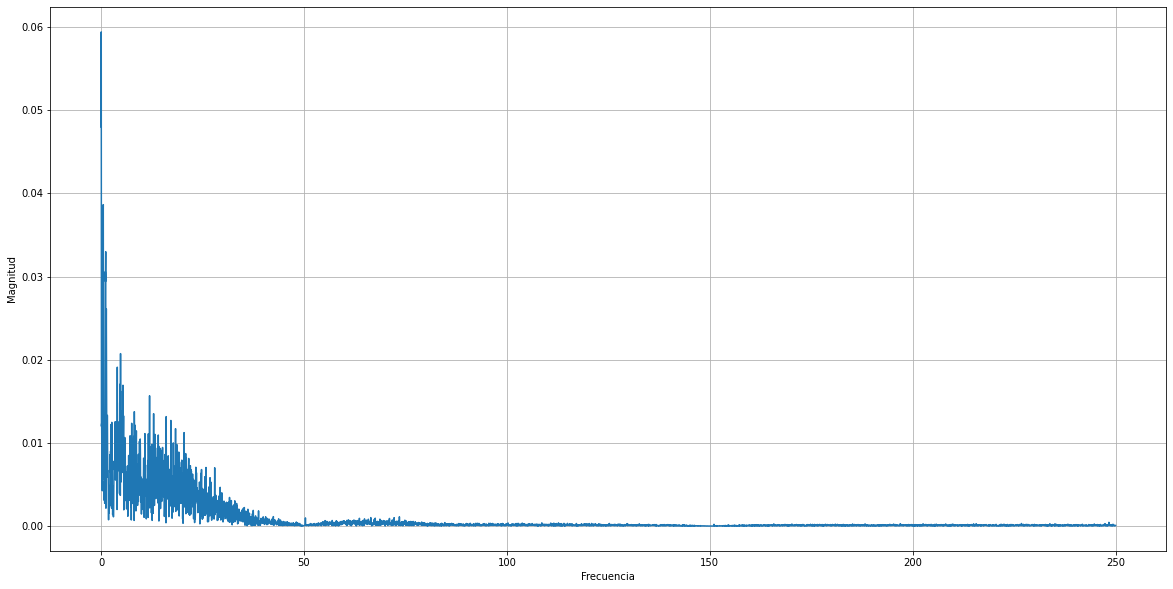

In [ ]:
# Analisis de Fourier de los filtros
# Periodo de 2ms (0.002s) o frecuencia de 500 Hz
T = 0.002
N = len(y)
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.figure(figsize=(20,10))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.xlabel("Frecuencia")
plt.ylabel("Magnitud")
plt.show()
ecg_signal = y

## **Ahora comencemos con la primera etapa del algoritmo: Filtro Pasa Banda**

Primero veamos el filtro Pasa Bajo con frecuencia de corte de 11 Hz.

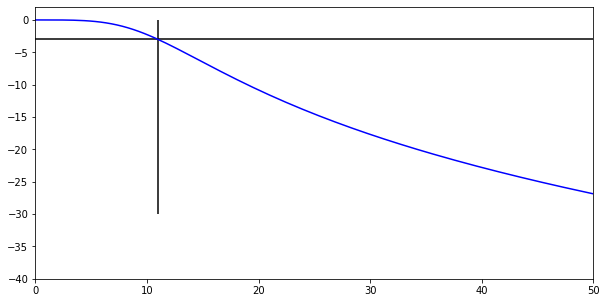

In [ ]:
from scipy.signal import freqz, iirdesign, iirfilter, find_peaks
# 2. filtro pasa banda
# Sub filtro pasa bajo
b, a = iirfilter(2, 11.0, btype='lowpass', rs=3, ftype='butter', fs=500)
w, h = freqz(b, a, fs=500)
plt.figure(figsize=(10,5))
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.hlines(-3,0,250)
plt.xlim(0,50)
plt.vlines(11, -30, 0)
plt.ylim(-40,2)
plt.show()

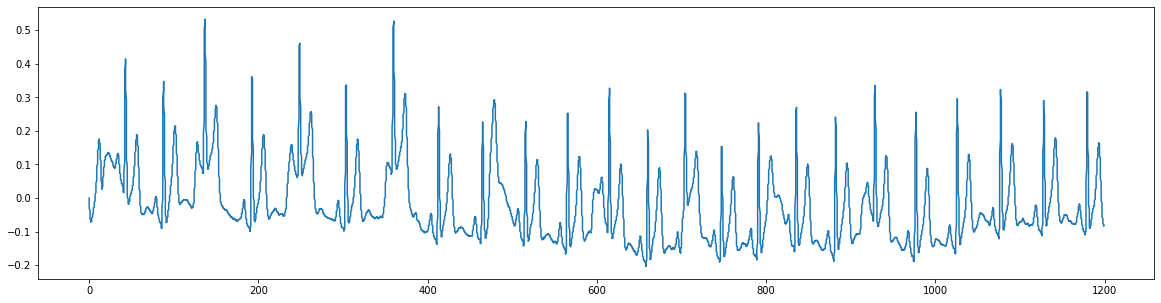

In [ ]:
fpb_signal = lfilter(b, a, ecg_signal)
plt.figure(figsize=(20,5))
plt.plot(mtime,fpb_signal)
plt.show()

Ahora veamos el filtro Pasa Alto con frecuencia de corte de 5 Hz

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


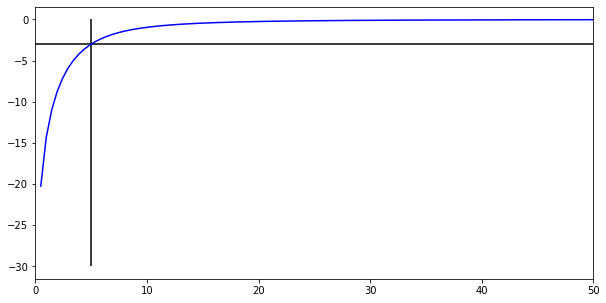

In [ ]:
b, a = iirfilter(1, 5.0, btype='highpass', rs=3, ftype='butter', fs=500)
w, h = freqz(b, a, fs=500)
plt.figure(figsize=(10,5))
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.hlines(-3,0,250)
plt.xlim(0,50)
plt.vlines(5, -30, 0)
plt.show()


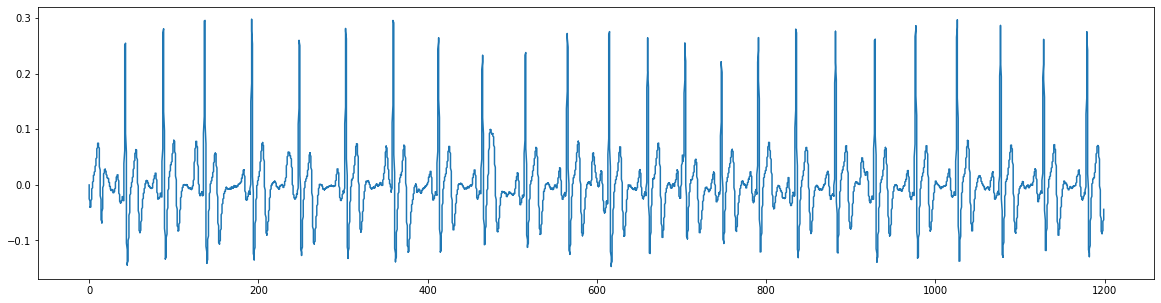

In [ ]:
fpa_signal = lfilter(b, a, fpb_signal)
plt.figure(figsize=(20,5))
plt.plot(mtime,fpa_signal)
plt.show()

## **Operador Derivativo**

En el paper nos dan la siguiente función que describe al operador:
$$y[n]=(1/8)(-x[n-2]-2x[n-1]+2x[n+1]+x[n+2])$$
Para que esta ecuación pueda ser utilizada necesitamos encuadrarla en un rango de $[0,+\infty]$ haciendo que $n=+2$ entonces tenemos:
$$y[n]=(1/8)(-x[n]-2x[n+1]+2x[n+3]+x[n+4])$$

Por lo tanto:
$$b = [-1, -2, 0, 2, 1]$$

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


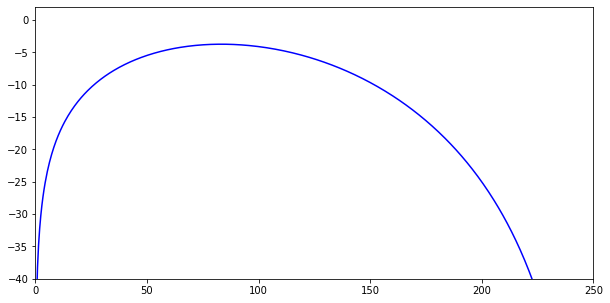

In [ ]:
# Filtro derivativo
b = np.array([-1, -2, 0, 2, 1])
b = (1/8)*b
w, h = freqz(b, 1, fs=500)
plt.figure(figsize=(10,5))
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.xlim(0,250)
plt.ylim(-40,2)
plt.show()

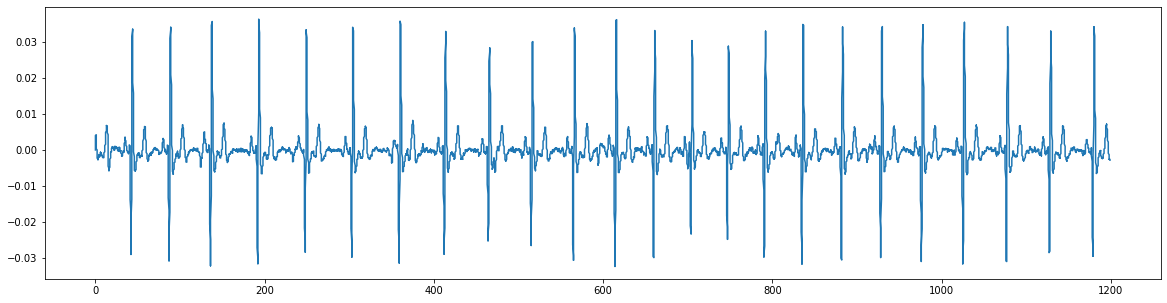

In [ ]:
fd_signal = lfilter(b, 1, fpa_signal)
plt.figure(figsize=(20,5))
plt.plot(mtime,fd_signal)
plt.show()

## **Operador Cuadrático**

Este operador solo tiene como función elevar al cuadrado los valores de la señal.

$$y[n]=x^2[n]$$

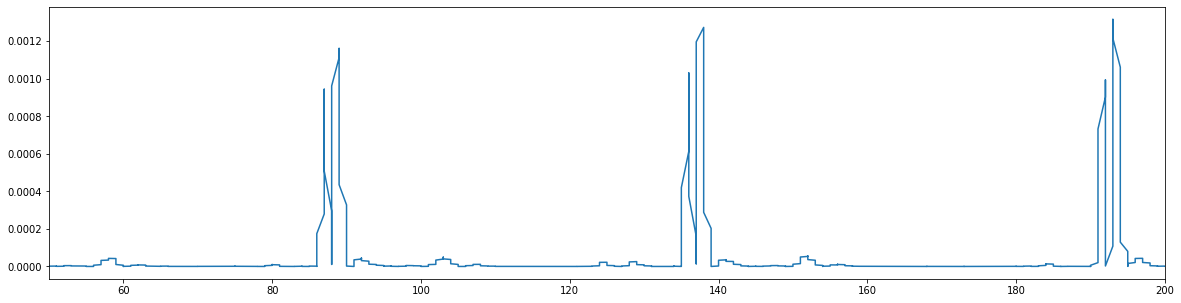

In [ ]:
# Filtro cuadrado
f_sq = np.square(fd_signal)
plt.figure(figsize=(20,5))
plt.plot(mtime, f_sq)
plt.xlim(50,200)
plt.show()

## **Operador Moving Window Integration**

Este operador tiene como función extraer ciertas características de la onda.
$$y[n]=(1/N)(x[n-(N-1)]+x[n-(N-2)]+..+x[n])$$

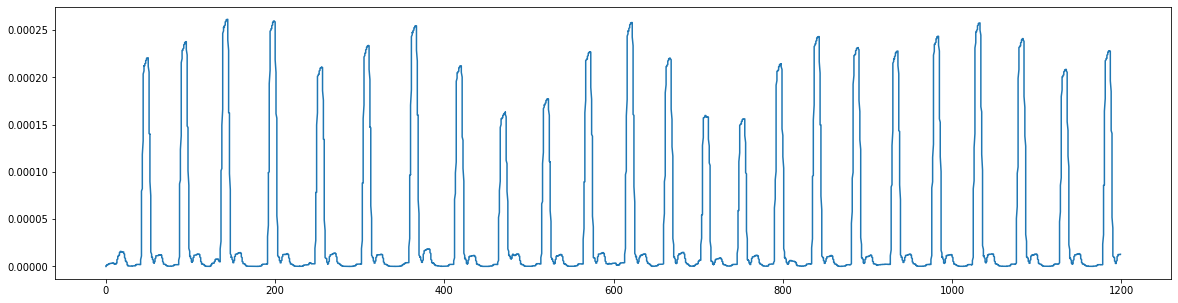

In [ ]:
# Moving-Window Integration
N = 75
b = np.ones(N-1)
b = (1/N)*b
fi_signal = lfilter(b, 1, f_sq)
plt.figure(figsize=(20,5))
plt.plot(mtime,fi_signal)
plt.show()

## **Fiducial Mark**

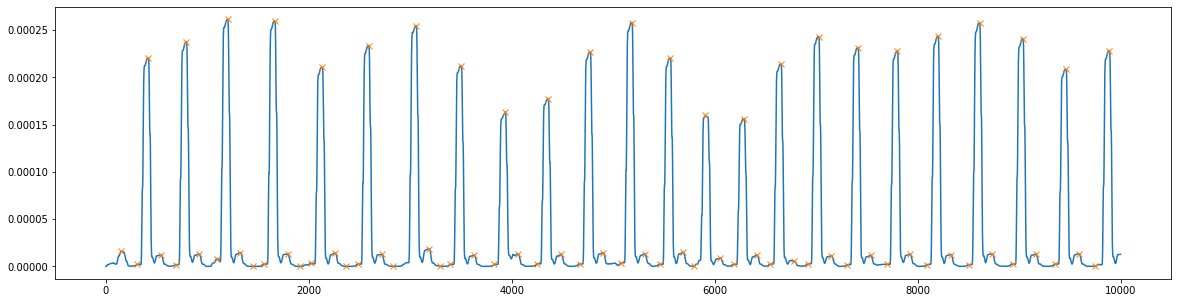

In [ ]:
# Fiducial Marks
peaks, _ = find_peaks(fi_signal, distance=100)
plt.figure(figsize=(20,5))
plt.plot(fi_signal)
plt.plot(peaks, fi_signal[peaks], "x")
plt.show()

## **Tarea**


Implementar la última parte del algoritmo.

